In [23]:
import numpy as np
import matplotlib.pyplot as plt

from correlator.helpers.simulation import GaussianSimulator
from correlator.correlator import ContextualCorrelator

## Contextualized Correlation with Multivariate Gaussians

In [57]:
p = 4  # Network dimension p^2
k = 2  # Number of true archetypes
c = 10  # Context dimension
k_n = 100  # Number of samples per archetype

sim = GaussianSimulator(p, k, c)
C, X = sim.gen_samples(k_n)
C.shape, X.shape

((200, 10), (200, 4))

In [64]:
model = ContextualCorrelator(c, p, p, num_archetypes=k * p**2 * 2)
model.fit(C, X, X, epochs=500, batch_size=1)

100%|██████████████████████████████████████| 500/500 [00:15<00:00, 32.48it/s]


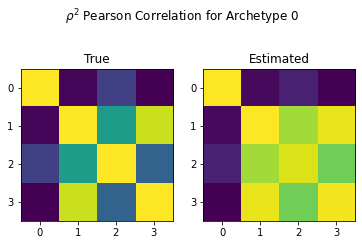

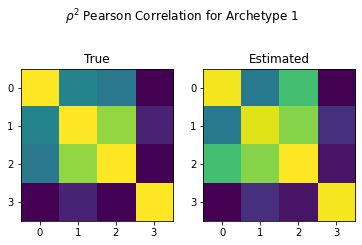

In [65]:
# Plot results
C_test, X_test = sim.gen_samples(1)
est_corrs = model.predict_correlation(C_test)

for i, true_sigma in enumerate(sim.sigmas):
    true_vars_tiled = np.tile(true_sigma.diagonal(), (p, 1)).T
    true_betas = true_sigma / true_vars_tiled  # beta[i,j] = beta_{i-->j}
    true_corr = np.power(true_sigma, 2) / (true_vars_tiled * true_vars_tiled.T)
    est_corr = est_corrs[i]
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(r'$\rho^2$ Pearson Correlation for Archetype {k}'.format(k=i))
    axs[0].set_title('True')
    axs[0].imshow(true_corr)
    axs[1].set_title('Estimated')
    axs[1].imshow(est_corr)

In [66]:
# Proportion of explained variance
from correlator.dataset import to_pairwise
mse = model.get_mse(C, X, X)
_, _, x, y = to_pairwise(C, X, X)
x = x.detach().numpy()
y = y.detach().numpy()
explained_var = 1 - mse / np.var(y)
print(f"Proportion of data variance explained by our model: {np.round(explained_var, 3)}")

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)
fx_global = reg.predict(x.reshape(-1, 1))
mse = np.mean(np.square(fx_global - y))
explained_var = 1 - mse / np.var(y)

print(f"Proportion of data variance explained by global regression: {np.round(explained_var, 3)}")

Proportion of data variance explained by our model: 0.452
Proportion of data variance explained by global regression: 0.006


## Dynamic Correlation with Simple Functions

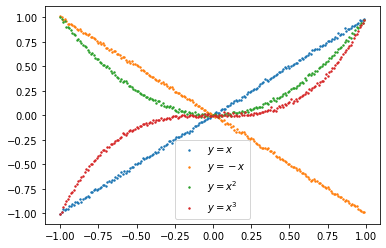

In [110]:
x_low, x_high, n = -1, 1, 200
x = np.arange(x_low, x_high, (x_high - x_low) / n)
C = x.reshape((len(x), 1))
X = np.array([x + np.random.normal(0, .01, n), 
              -x + np.random.normal(0, .01, n),
              x**2 + np.random.normal(0, .01, n),
              x**3 + np.random.normal(0, .01, n),
             ]
            ).T

plt.scatter(C[:,0], X[:,0], s=2, label=r'$y=x$')
plt.scatter(C[:,0], X[:,1], s=2, label=r'$y=-x$')
plt.scatter(C[:,0], X[:,2], s=2, label=r'$y=x^2$')
plt.scatter(C[:,0], X[:,3], s=2, label=r'$y=x^3$')
plt.legend()
plt.show()

In [111]:
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(.2 * len(X))
train_idx = idx[:-split]
test_idx = idx[-split:]
C_train, X_train = C[train_idx], X[train_idx]
C_test, X_test = C[test_idx], X[test_idx]

In [116]:
c = 1
p = 4
model = ContextualCorrelator(c, p, p, num_archetypes=3 * p ** 2)
model.fit(C_train, X_train, X_train, 1000, 1)

100%|████████████████████████████████████| 1000/1000 [00:33<00:00, 29.97it/s]


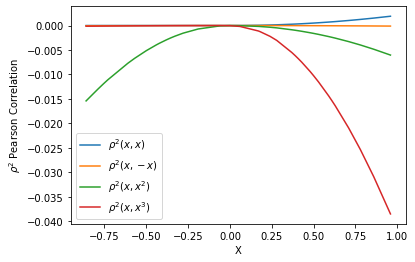

In [118]:
# How confusing!
C_test = np.sort(C_test, axis=0)
corrs = model.predict_correlation(C_test)
plt.plot(C_test, corrs[:,0,0], label=r'$\rho^2(x, x)$')
plt.plot(C_test, corrs[:,0,1], label=r'$\rho^2(x, -x)$')
plt.plot(C_test, corrs[:,0,2], label=r'$\rho^2(x, x^2)$')
plt.plot(C_test, corrs[:,0,3], label=r'$\rho^2(x, x^3)$')
plt.ylabel(r'$\rho^2$ Pearson Correlation')
plt.xlabel('X')
plt.legend()
plt.show()